In [184]:
#gather original df

import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from scipy import stats

#get plots to show up in jn
%matplotlib inline
#get plots to be an svg when exporting
%config InlineBackend.figure_format = 'svg'

In [185]:
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)
        
# week_nums = [180407, 180414, 180421, 180428, 180505, 180512, 180519, 180526, 180602, 180609, 180616, 180623]
week_nums = [180407, 180414, 180421, 180428]
data = get_data(week_nums)
data.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/31/2018,00:00:00,REGULAR,6566463,2224050
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/31/2018,04:00:00,REGULAR,6566470,2224053
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/31/2018,08:00:00,REGULAR,6566470,2224053
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/31/2018,12:00:00,REGULAR,6566470,2224055
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/31/2018,16:00:00,REGULAR,6566470,2224055


In [186]:
#cleaning up data

df = data.copy()

df.columns = [column.strip() for column in df.columns]

df['STATION'].apply(lambda x: x.strip());

In [187]:
#get datetime column
df["DATE_TIME"] = pd.to_datetime(df.DATE + " " + df.TIME, format="%m/%d/%Y %H:%M:%S")

#drop dupes

df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True, ascending=False)

df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

df = df.drop(["EXITS", "DESC"], axis=1, errors="ignore");

In [188]:
#sort so prev entries will work
(df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False));

In [189]:
#put in prev entries column
df_daily = df.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"])\
.ENTRIES.first().reset_index().copy()

df_daily[["PREV_DATE", "PREV_ENTRIES"]] = (df_daily.groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES"].transform(lambda grp: grp.shift(1)));

In [190]:
#fix daily counts

def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        #print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
        # if current entries is bad, use yesterday's count as proxy
    if counter > max_counter:
        # Check it again to make sure we are not giving a counter that's too big
        return 0
    return counter

df_daily.apply(get_daily_counts, axis=1, max_counter=1000000);

In [191]:
#subtract prev values to make daily entries column
df_daily["DAILY_ENTRIES"] = df_daily.apply(get_daily_counts, axis=1, max_counter=1000000);

In [192]:
df_daily_sta = df_daily.groupby(['STATION', 'DATE'])['DAILY_ENTRIES'].sum().reset_index().sort_values(['DATE'])

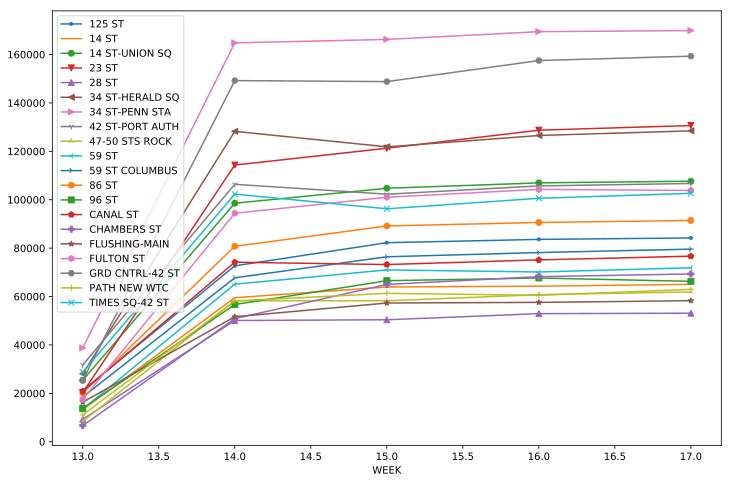

In [197]:
df_wk_medians = df_daily_sta.groupby(['STATION','DATE'])['DAILY_ENTRIES'].sum().reset_index().sort_values(['DAILY_ENTRIES'], ascending=False)        
df_wk_medians['WEEK'] = pd.to_datetime(df_wk_medians['DATE'], format="%m/%d/%Y").dt.week
df_wk_medians = df_wk_medians.groupby(['STATION','WEEK'])['DAILY_ENTRIES'].agg(['median']).reset_index().sort_values(['median'],ascending=False)
df_wk_medians_top20 = df_wk_medians.loc[df_wk_medians.STATION.isin(df_medians_top20.STATION), :].reset_index().sort_values(['WEEK','STATION'])

mrk = [".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|"]
mrkn = 0
a = df_wk_medians_top20
fig, ax = plt.subplots(figsize=(12,8))
for key, grp in a.groupby(['STATION']):
    mrkn = mrkn % 24
    ax = grp.plot(ax=ax, kind='line', x='WEEK', y='median', label=key, marker=mrk[mrkn])
    mrkn +=1
plt.legend(loc='best')
plt.show();

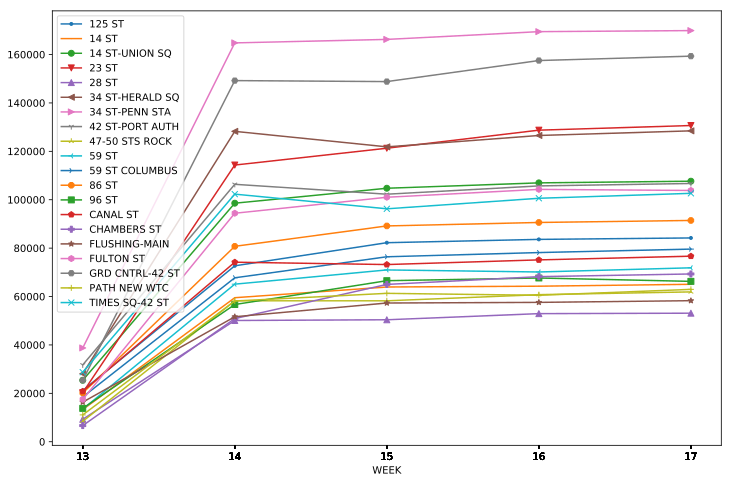

In [195]:
df_wk_medians = df_daily_sta.groupby(['STATION','DATE'])['DAILY_ENTRIES'].sum().reset_index().sort_values(['DAILY_ENTRIES'], ascending=False)        
df_wk_medians['WEEK'] = pd.to_datetime(df_wk_medians['DATE'], format="%m/%d/%Y").dt.week
df_wk_medians = df_wk_medians.groupby(['STATION','WEEK'])['DAILY_ENTRIES'].agg(['median']).reset_index().sort_values(['median'],ascending=False)
df_wk_medians_top20 = df_wk_medians.loc[df_wk_medians.STATION.isin(df_medians_top20.STATION), :].reset_index().sort_values(['WEEK','STATION'])

a = df_wk_medians_top20
mrkn = 0
fig, ax = plt.subplots(figsize=(12,8))
for key, grp in a.groupby(['STATION']):
    mrkn = mrkn % 24
    ax = grp.plot(ax=ax, kind='line', x='WEEK', y='median', label=key, marker=mrk[mrkn])
    mrkn += 1

plt.xticks(b.WEEK)    
plt.legend(loc='best')
plt.show();

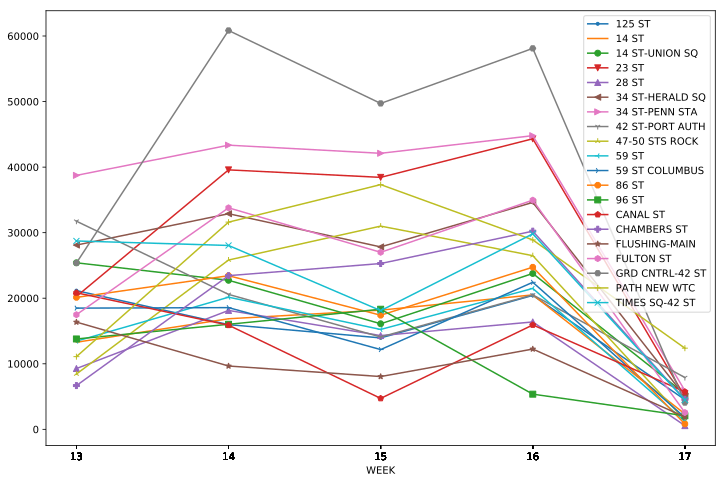

In [196]:
df_wk_iqr = df_daily_sta.groupby(['STATION','DATE'])['DAILY_ENTRIES'].sum().reset_index().sort_values(['DAILY_ENTRIES'], ascending=False)        
df_wk_iqr['WEEK'] = pd.to_datetime(df_wk_iqr['DATE'], format="%m/%d/%Y").dt.week
df_wk_iqr = df_wk_iqr.groupby(['STATION','WEEK'])['DAILY_ENTRIES'].agg([stats.iqr]).reset_index().sort_values(['iqr'],ascending=False)
df_wk_iqr_top20 = df_wk_iqr.loc[df_wk_iqr.STATION.isin(df_medians_top20.STATION), :].reset_index().sort_values(['WEEK','STATION'])

b = df_wk_iqr_top20
mrkn = 0
fig, ax = plt.subplots(figsize=(12,8))
for key, grp in b.groupby(['STATION']):
    mrkn = mrkn % 24
    ax = grp.plot(ax=ax, kind='line', x='WEEK', y='iqr', label=key, marker=mrk[mrkn])
    mrkn += 1

plt.xticks(b.WEEK)
plt.legend(loc='best')
plt.show();